INFO:__main__:Rendering on GPU...


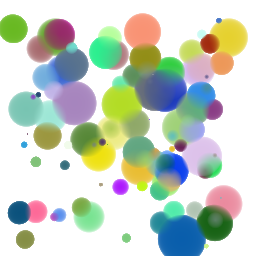

In [55]:
import logging
from os import path

import imageio
import torch

# Import `look_at_view_transform` as needed in the suggestion later in the
# example.
from pytorch3d.renderer import PerspectiveCameras  # , look_at_view_transform
from pytorch3d.renderer import (
    PointsRasterizationSettings,
    PointsRasterizer,
    PulsarPointsRenderer,    
)

from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor
)


from pytorch3d.structures import Pointclouds


LOGGER = logging.getLogger(__name__)


"""
Basic example for the pulsar sphere renderer using the PyTorch3D interface.
Writes to `basic-pt3d.png`.
"""
LOGGER.info("Rendering on GPU...")
torch.manual_seed(1)
n_points = 100
width = 256
height = 256
device = torch.device("cuda")
# Generate sample data.
vert_pos = torch.rand(n_points, 3, dtype=torch.float32, device=device) * 10.0
vert_pos[:, 2] += 25.0
vert_pos[:, :2] -= 5.0
vert_col = torch.rand(n_points, 3, dtype=torch.float32, device=device)
pcl = Pointclouds(points=vert_pos[None, ...], features=vert_col[None, ...])
# Alternatively, you can also use the look_at_view_transform to get R and T:
# R, T = look_at_view_transform(
#     dist=30.0, elev=0.0, azim=180.0, at=((0.0, 0.0, 30.0),), up=((0, 1, 0),),
# )
cameras = PerspectiveCameras(
    # The focal length must be double the size for PyTorch3D because of the NDC
    # coordinates spanning a range of two - and they must be normalized by the
    # sensor width (see the pulsar example). This means we need here
    # 5.0 * 2.0 / 2.0 to get the equivalent results as in pulsar.
    focal_length=(5.0 * 2.0 / 2.0,),
    R=torch.eye(3, dtype=torch.float32, device=device)[None, ...],
    T=torch.zeros((1, 3), dtype=torch.float32, device=device),
    image_size=((width, height),),
    device=device,
)
vert_rad = torch.rand(n_points, dtype=torch.float32, device=device)
raster_settings = PointsRasterizationSettings(
    image_size=(width, height),
    radius=vert_rad,
)
rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
renderer = PulsarPointsRenderer(rasterizer=rasterizer).to(device)
# Render.
image = renderer(
    pcl,
    gamma=(1.0e-1,),  # Renderer blending parameter gamma, in [1., 1e-5].
    znear=(1.0,),
    zfar=(45.0,),
    radius_world=True,
    bg_col=torch.ones((3,), dtype=torch.float32, device=device),
)[0]



Image.fromarray((image.cpu().detach() * 255.0).to(torch.uint8).numpy())

In [7]:
from pytorch3d.utils import ico_sphere, torus
from pytorch3d.ops import sample_points_from_meshes

src_mesh = ico_sphere(4, device)

vertices, normals= sample_points_from_meshes(src_mesh, n_points, 
    return_normals=True)
vertices.shape, normals.shape

(torch.Size([1, 10, 3]), torch.Size([1, 10, 3]))

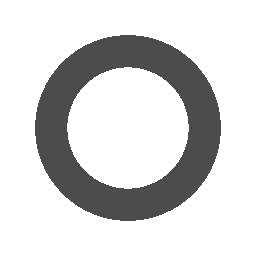

In [53]:
# Generate sample data.
n_points = 300000
vert_pos = torch.rand(n_points, 3, dtype=torch.float32, device=device) * 10.0
vert_pos[:, 2] += 25.0
vert_pos[:, :2] -= 5.0
vert_col = torch.rand(n_points, 3, dtype=torch.float32, device=device)
pcl = Pointclouds(points=vert_pos[None, ...], features=vert_col[None, ...])

src_mesh = ico_sphere(4, device)
src_mesh =  torus(0.2, 1.0, 64, 64, device)
vertices, normals= sample_points_from_meshes(src_mesh, n_points, 
    return_normals=True)
vertices.shape, normals.shape

vertices[:, :, 2] += 25.0
vertices[:, :, :2] -= 0.0
vert_col = torch.full((n_points, 3), 0.3, dtype=torch.float32, device=device)
pcl = Pointclouds(points=vertices, 
                  normals=normals,
                  features=vert_col[None, ...],
                 )
# Alternatively, you can also use the look_at_view_transform to get R and T:
# R, T = look_at_view_transform(
#     dist=30.0, elev=0.0, azim=180.0, at=((0.0, 0.0, 30.0),), up=((0, 1, 0),),
# )
cameras = PerspectiveCameras(
    # The focal length must be double the size for PyTorch3D because of the NDC
    # coordinates spanning a range of two - and they must be normalized by the
    # sensor width (see the pulsar example). This means we need here
    # 5.0 * 2.0 / 2.0 to get the equivalent results as in pulsar.
    focal_length=(15.0 * 2.0 / 2.0,),
    R=torch.eye(3, dtype=torch.float32, device=device)[None, ...],
    T=torch.zeros((1, 3), dtype=torch.float32, device=device),
    image_size=((width, height),),
    device=device,
)
vert_rad = torch.rand(n_points, dtype=torch.float32, device=device)
vert_rad =  torch.full((n_points,), 0.001, dtype=torch.float32, device=device)
raster_settings = PointsRasterizationSettings(
    image_size=(width, height),
    radius=vert_rad,
)
rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
renderer = PulsarPointsRenderer(rasterizer=rasterizer).to(device)
# Render.
image = renderer(
    pcl,
    gamma=(1.0e-1,),  # Renderer blending parameter gamma, in [1., 1e-5].
    znear=(1.0,),
    zfar=(45.0,),
    radius_world=True,
    bg_col=torch.ones((3,), dtype=torch.float32, device=device),
)[0]



Image.fromarray((image.cpu().detach() * 255.0).to(torch.uint8).numpy())         

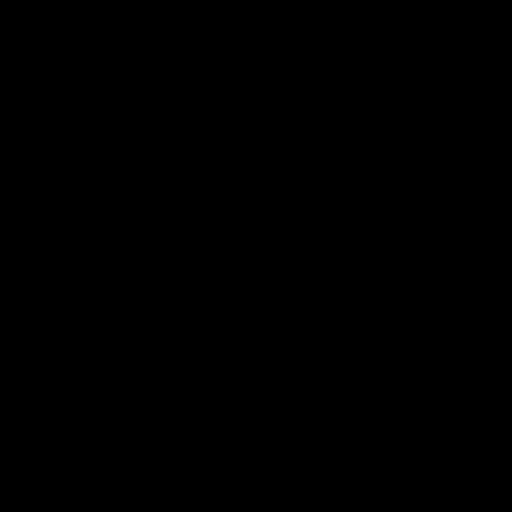

In [58]:
R, T = look_at_view_transform(20, 10, 0)
cameras = FoVOrthographicCameras(device=device, R=R, T=T, znear=0.01)


raster_settings = PointsRasterizationSettings(
    image_size=512, 
    radius = 0.003,
    points_per_pixel = 10
)


# Create a points renderer by compositing points using an alpha compositor (nearer points
# are weighted more heavily). See [1] for an explanation.
rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
renderer = PointsRenderer(
    rasterizer=rasterizer,
    compositor=AlphaCompositor()
)


image = renderer(pcl)[0]



Image.fromarray((image.cpu().detach() * 255.0).to(torch.uint8).numpy())         


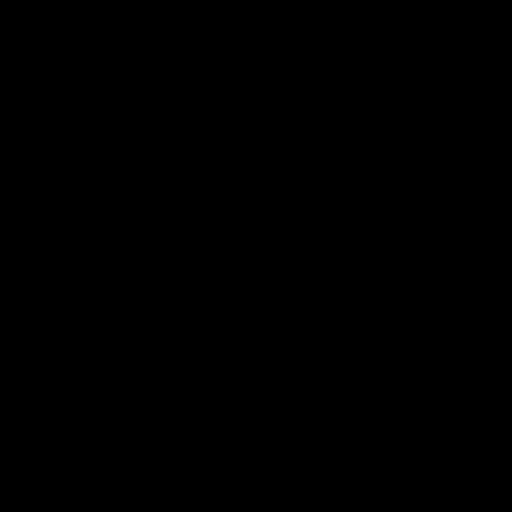

In [63]:
renderer = PointsRenderer(
    rasterizer=rasterizer,
    # Pass in background_color to the alpha compositor, setting the background color 
    # to the 3 item tuple, representing rgb on a scale of 0 -> 1, in this case blue
    compositor=AlphaCompositor(background_color=(1., 1., 1.))
)
image = renderer(pcl)[0]
Image.fromarray((image.cpu().detach() * 255.0).to(torch.uint8).numpy())         